# Настройки/Импорты

In [1]:
!pip install evaluate
!pip install seaborn==0.13.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
import os # для работы с системой
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import random as random # для работы со случайностью
import pickle # для сохранения и загрузки объектов
import re # для работы с регулярными выражениями
from tqdm.auto import tqdm # для отслеживания прогресса

from datasets import Dataset, load_dataset, load_from_disk # для работы с HuggingFace датасетами

import torch # для работы с моделями torch
from transformers import AutoModelForCausalLM, AutoTokenizer # для работы с моделью
from transformers import DataCollatorForSeq2Seq # для сборщика данных (чтобы)
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer # для обучения модели
from transformers import EarlyStoppingCallback # callback для ранней остановки обучения

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для построения красивых графиков
import evaluate # для подсчёта метрик

In [3]:
DATA_DIR = "/kaggle/working/data/" # путь до папки с данными
RESULTS_DIR = "/kaggle/working/results/" # путь до папки с результатами вычислений
EMBEDDING_DIR = "/kaggle/working/embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "/kaggle/working/models/" # путь до папки с моделями
MODEL_NAME = "Vikhrmodels/Vikhr-Llama-3.2-1B-instruct" # название модели для перевода
DATASET_NAME_HF = "aiana94/polynews-parallel"
DATASET_NAME_LOC = "polynews-parallel"

MAX_SEQUENCE_LEN = 256 # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation), определялось по гистограмме распределения числа токенов в текстах

RANDOM_STATE = 42 # число для задания случайности
TEST_SIZE = 0.2 # размер тестовой выборки
TEST_MAX_SAMPLES = 500 # максимальное число тестовых примеров
TRAIN_MAX_SAMPLES = 40000 # максимальное число обучающих примеров

EPOCHS = 10 # число эпох обучения
EPOCHS_PATIENCE = 2 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
LEARNING_RATE = 0.00001 # learning rate
BATCH_SIZE = 24 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [4]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Девайс: {DEVICE}.")

Девайс: cpu.


# Работа с датасетом

In [5]:
dataset = load_dataset(DATASET_NAME_HF, name="eng_Latn-rus_Cyrl") # скачивание датасета, name — название subset_а с HuggingFace
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC) # локальное сохранение датасета (в формате arrow)
dataset

README.md:   0%|          | 0.00/107k [00:00<?, ?B/s]

train.parquet.gzip:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176441 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'provenance'],
        num_rows: 176441
    })
})

In [6]:
dataset["train"][0]

{'src': 'Parliament Does Not Support Amendment Freeing Tymoshenko',
 'tgt': 'Парламент не поддерживает поправку, дающую свободу Тимошенко',
 'provenance': 'wmtnews'}

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME) # сохранение токенизатора
tokenizer

tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='Vikhrmodels/Vikhr-Llama-3.2-1B-instruct', vocab_size=128000, model_max_length=4096, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>', 'pad_token': '<|reserved_special_token_0|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	12

In [8]:
def preprocess_function(data: Dataset, random_state=RANDOM_STATE):
    random.seed(random_state) # Set the random number generator to a fixed sequence.
    samples_count = len(dataset["train"]) # общее число сэмплов в датасете

    reflected_idx = set(random.sample(range(0, samples_count), int(samples_count/2))) # индексы отражаемых сэмплов (set — для сортировки и удобного вычитания)
    regular_idx = set(range(0, samples_count)) - reflected_idx

    # data["new_src"] = ["translate to ru: " + sample if idx in regular_idx else "translate to en: " + data["tgt"][idx] for idx, sample in enumerate(data["src"])]
    data["new_src"] = [sample if idx in regular_idx else data["tgt"][idx] for idx, sample in enumerate(data["src"])]
    data["new_tgt"] = [sample if idx in regular_idx else data["src"][idx] for idx, sample in enumerate(data["tgt"])]
    data["lang_from"] = ["English" if idx in regular_idx else "Russian" for idx, sample in enumerate(data["src"])]
    data["lang_to"] = ["Russian" if idx in regular_idx else "English" for idx, sample in enumerate(data["tgt"])]
    model_inputs = tokenizer(data["new_src"], text_target=data["new_tgt"], max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True)
    return model_inputs

In [9]:
dataset = dataset.map(preprocess_function, batched=True)
dataset = dataset.remove_columns(["provenance", "src", "tgt"]) # удаление ненужной колонки
dataset = dataset.rename_column("new_src", "src") # переименовываем колонку
dataset = dataset.rename_column("new_tgt", "tgt") # переименовываем колонку
dataset = dataset["train"].train_test_split(test_size=TEST_SIZE, shuffle=True, seed=RANDOM_STATE) # разбиение датасета на тестовую и обучающую выборки ()
dataset

Map:   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'lang_from', 'lang_to', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 141152
    })
    test: Dataset({
        features: ['src', 'tgt', 'lang_from', 'lang_to', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 35289
    })
})

In [10]:
dataset["train"][0]

{'src': "Diaspora blogger Jumbie's Watch was also confused as to how Minister St. Rose-Greaves was spared, since he remembers her publicly accepting responsibility. ",
 'tgt': "Один из авторов блога Jumbie's Watch также был потрясен тем, как министр Сент-Роуз Гривз была избавлена от ответственности, хотя помнится она публично признала её. ",
 'lang_from': 'English',
 'lang_to': 'Russian',
 'input_ids': [128000,
  35,
  3557,
  71764,
  40281,
  622,
  3635,
  648,
  596,
  10573,
  574,
  1101,
  22568,
  439,
  311,
  1268,
  9675,
  800,
  13,
  16344,
  12279,
  265,
  4798,
  574,
  74688,
  11,
  2533,
  568,
  43457,
  1077,
  17880,
  25694,
  12014,
  13,
  220,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
  128002,
 

In [11]:
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC + "_llama3_2_processed") # локальное сохранение датасета (в формате arrow)
# dataset = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_llama3_2_processed") # загрузка локально сохранённого датасета

Saving the dataset (0/1 shards):   0%|          | 0/141152 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35289 [00:00<?, ? examples/s]

# Работа с моделью

In [12]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.save_pretrained(MODELS_DIR + MODEL_NAME, from_pt=True) # сохранение модели
model

config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [13]:
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME) # сохранение токенизатора
# tokenizer

In [14]:
vocab_len = tokenizer.vocab_size # размер словаря
print(f"Размер словаря токенизатора: {vocab_len}, с учётом особых токенов: {len(tokenizer.get_vocab())}.")

Размер словаря токенизатора: 128000, с учётом особых токенов: 128256.


In [15]:
word2id = {} # словарь соответствия слова его id_шнику
id2word = {} # словарь соответствия id_шника слову
for word, id in tokenizer.get_vocab().items(): # идём по словам в словаре
    word2id[word] = id # заполняем словарь соответствия слова его id_шнику
    id2word[id] = word # заполняем словарь соответствия id_шника слову

In [16]:
text = "Цель разработки — предоставить пользователям личного синхронного переводчика."

lang_from = "Russian"
lang_to = "English"

# messages = [
#     # {"role": "system", "content": f"You are advanced translation assistant, translate the following text from {lang_from} to {lang_to}. Provide only the translation without any additional comments or explanations."},
#     {"role": "system", "content": f"You are advanced translation assistant, translate the following text to {lang_to} language. Provide only the translation without any additional comments or explanations."},
#     {"role": "user", "content": text},
# ]

src_text = f"You are advanced translation assistant which provides only the translation without any additional comments, explanations or prompts. Translate the following text to {lang_to} language:\n\n{text}"

tokens_encoded = tokenizer(src_text, max_length=tokenizer.max_len_single_sentence, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
# tokens_encoded = tokenizer.apply_chat_template(
#     messages,
#     add_generation_prompt=True,
#     max_length=tokenizer.max_len_single_sentence,
#     return_tensors="pt", 
#     truncation=True, 
#     padding=True
# )

print(f"Пример токенизации документа: {tokens_encoded}.") # пример токенизации первого документа

Пример токенизации документа: {'input_ids': tensor([[128000,   2675,    527,  11084,  14807,  18328,    902,   5825,   1193,
            279,  14807,   2085,    904,   5217,   6170,     11,  41941,    477,
          52032,     13,  38840,    279,   2768,   1495,    311,   6498,   4221,
           1473,  93899,  26503, 117143,  17165,   2001, 115739,  18264,  67249,
           6578, 110072,  39900, 106800,  10693, 103710,  39900, 105055,   9706,
         118122,     13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}.


In [17]:
for token in tokens_encoded['input_ids'][0].numpy(): # идём по токенам
# for token in tokens_encoded[0].numpy(): # идём по токенам
    print(f"{token} — {id2word[token]}") # выводим токен (id) и соответствующее ему слово

128000 — <|begin_of_text|>
2675 — You
527 — Ġare
11084 — Ġadvanced
14807 — Ġtranslation
18328 — Ġassistant
902 — Ġwhich
5825 — Ġprovides
1193 — Ġonly
279 — Ġthe
14807 — Ġtranslation
2085 — Ġwithout
904 — Ġany
5217 — Ġadditional
6170 — Ġcomments
11 — ,
41941 — Ġexplanations
477 — Ġor
52032 — Ġprompts
13 — .
38840 — ĠTranslate
279 — Ġthe
2768 — Ġfollowing
1495 — Ġtext
311 — Ġto
6498 — ĠEnglish
4221 — Ġlanguage
1473 — :ĊĊ
93899 — Ð¦
26503 — ÐµÐ»ÑĮ
117143 — ĠÑĢÐ°Ð·ÑĢÐ°Ð±Ð¾ÑĤ
17165 — ÐºÐ¸
2001 — ĠâĢĶ
115739 — ĠÐ¿ÑĢÐµÐ´Ð¾ÑģÑĤÐ°Ð²
18264 — Ð¸ÑĤÑĮ
67249 — ĠÐ¿Ð¾Ð»ÑĮÐ·Ð¾Ð²Ð°ÑĤÐµÐ»Ñı
6578 — Ð¼
110072 — ĠÐ»Ð¸Ñĩ
39900 — Ð½Ð¾Ð³Ð¾
106800 — ĠÑģÐ¸Ð½
10693 — Ñħ
103710 — ÑĢÐ¾Ð½
39900 — Ð½Ð¾Ð³Ð¾
105055 — ĠÐ¿ÐµÑĢÐµÐ²
9706 — Ð¾Ð´
118122 — ÑĩÐ¸ÐºÐ°
13 — .


In [18]:
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

tokens_generated = model.generate(**tokens_encoded,
# tokens_generated = model.generate(tokens_encoded,   
                                  max_length=MAX_SEQUENCE_LEN,
                                  eos_token_id=terminators,
                                  temperature=0.0001,
                                  num_return_sequences=1,
                                  no_repeat_ngram_size=2,
                                  top_k=50,
                                  top_p=0.95,
                                  pad_token_id=tokenizer.eos_token_id
                                 )

tokens_generated = tokens_generated[:,tokens_encoded["input_ids"].shape[-1]:] # срезаем токены, что продублировались из промпта

output = tokenizer.batch_decode(tokens_generated, skip_special_tokens=True)
# output = tokenizer.batch_decode(tokens_generated, skip_special_tokens=False)
print(output)

[' Он должен быть способен перевести тексты на русский язык, а также на другие языки, включая английский. Целью разработчика является создание продукта, который будет использоваться в различных контекстах, например, в социальных сетях, на веб-сайтах и в мобильных приложениях. Программа должна быть простой в использовании и легко интегрироваться с существующими сервисами. Важно, чтобы пользователь мог легко найти и использовать программу, не требуя дополнительных настроек или настройки. Обратите внимание, что программы, которые предлагаются на рынке, часто имеют ограниченные возможности и не могут выполнять все задачи, требующие перевода. Поэтому разработчик должен обеспечить, если это возможно, дополнительные функции для улучшения качества переводы. Это может быть, для примера, добавление функций для автоматического переводу']


# Baseline (замер основных метрик)

In [19]:
def translate(model, tokenizer, data) -> tuple:
    tokens_count = [] # список под количество токенов в тексте
    latency = [] # список под величину задержки между запуском модели и выводом ответа
    translations = [] # список под переводы

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    
    # if isinstance(data, str): # если пришёл объект типа строки
    #     texts = [data] # делаем из объекта список с одним элементом
    if isinstance(data, Dataset) or isinstance(data, dict): # если пришёл объект типа Dataset или словарь (полученный с помощью среза объекта Dataset)
        texts = data["src"] # берём из него только текста, что нужно переводить
        langs_to = data["lang_to"] # запоминаем, на какой язык нужно перевести

    model.eval() # перевод модели в режим оценивания (dropout перестаёт работать, а BatchNorm собирать статистику)

    with torch.no_grad(): # отключаем подсчёт градиентов
        #================================ Быстрый перевод батчами ==========================================
        # tokens_encoded = tokenizer(texts, max_length=tokenizer.max_len_single_sentence, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
        # tokens_generated = model.generate(**tokens_encoded)
        # translations = tokenizer.batch_decode(tokens_generated, skip_special_tokens=True) # декодирование последовательности токенов (аналог .decode, но для работы с несколькими последовательностями сразу), skip_special_tokens — выводить ли специальные токены
        #-------------------------------- Перевод для учёта времени работы ---------------------------------
        for text, lang_to in tqdm(zip(texts, langs_to)):
            text = f"You are advanced translation assistant which provides only the translation without any additional comments, explanations or prompts. Translate the following text to {lang_to} language:\n\n{text}" # добавляем промпт для того, чтобы модель знала, что нужно делать
            time_start = time.time() # замеряем время начала работы  с моделью
    
            tokens_encoded = tokenizer(text, max_length=tokenizer.max_len_single_sentence, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
            tokens_count.append(tokens_encoded["input_ids"].shape[1]) # запоминаем количество токенов

            tokens_generated = model.generate(**tokens_encoded, # генерируем новую последовательность токенов (переводим текст)
                                              max_length=MAX_SEQUENCE_LEN,
                                              eos_token_id=terminators,
                                              temperature=0.0001,
                                              num_return_sequences=1,
                                              no_repeat_ngram_size=2,
                                              top_k=50,
                                              top_p=0.95,
                                              pad_token_id=tokenizer.eos_token_id
                                             )

            tokens_generated = tokens_generated[:,tokens_encoded["input_ids"].shape[-1]:] # срезаем токены, что продублировались из промпта
            
            translations.append(tokenizer.decode(tokens_generated[0], skip_special_tokens=True)) # декодирование последовательности токенов, skip_special_tokens — выводить ли специальные токены

            latency.append(time.time()  - time_start)
        #---------------------------------------------------------------------------------------------------
    
    return tokens_count, latency, translations

In [20]:
tokens_count, latency, translations = translate(model, tokenizer, dataset["test"][:TEST_MAX_SAMPLES])

0it [00:00, ?it/s]

In [21]:
translations[:5]

[' The device is designed to be used by parents and healthcare professionals to quickly and easily test for HIV in their children. The partnership is expected to lead to a significant reduction in the number of cases of late HIV diagnosis in children, which is a major concern for public health.',
 ' В то же время, эти меры могут привести к созданию более сложных и разнообразных политических систем, где каждый член партии может иметь возможность влиять на политическую ситуацию. Это может привести не только к политическим, но и к социальным и экономическим последствиям. \n\n---\n\n**Перевод на английский язык:**\n\nHowever, the restrictions on two popular shows indicate that party leaders are expanding the powers of the authorities regarding electoral censorship and regulation of content that goes against their ideology. At the same time, these measures could lead to the creation of more complex and diverse political systems where each member of a party can have the opportunity to influe

In [22]:
dataset["test"]["src"][:5]

['The Clinton Foundation and the telecommunications operator MTN have partnered to fight against the late diagnosis of HIV testing in newborns. This new mobile device will include a pocket-size printer and will be distributed in 682 testing centers across the country. ',
 'Однако запрещение двух популярных сериалов показывает, что партийные руководства расширяют полномочия властей относительно избирательной цензуры и регулирования контента, идущего против их идеологии. ',
 'It is not surprising that words become spells to help stop the crying, help the child go to sleep, or express encouragement or hope. ',
 'Сейчас сторонники обращаются к генеральному секретарю ООН Пан Ги Муну с просьбой оказать поддержку международным обязательствам в области прав человека и потребовать немедленного освобождения Басселя. ',
 'This story by Joyce Hackel originally appeared on PRI.org on June 14, 2017. ']

In [23]:
dataset["test"]["tgt"][:5]

['Фонд Клинтона предполагает внедрить устройство, оснащенное минипринтером, в 682 центрах по забору крови по всей стране. ',
 'Yet, as the takedown of the two popular online TV series indicated, the party guidelines empower authorities to arbitrarily and selectively censor and ban content that they find challenges their ideology. ',
 'Не удивительно, что слова становятся заклинаниями, для того чтобы помочь остановить плач, помочь ребенку заснуть, выразить поддержку или надежду. ',
 "Supporters are now turning to the United Nations’ Secretary-General Ban Ki-moon and asking for his support to uphold international commitments to human rights and demand Bassel's immediate and safe release. ",
 'Эта статья Джойс Хакел изначально была опубликована на PRI.org 14 июня 2017г. ']

In [24]:
if not os.path.exists(RESULTS_DIR + MODEL_NAME):
    os.makedirs(RESULTS_DIR + MODEL_NAME)

with open(RESULTS_DIR + MODEL_NAME + "/tokens_count.pkl", "wb") as f: # открываем файл для записи по битам (wb)
    pickle.dump(tokens_count, f) # сохраняем объект в файл f
with open(RESULTS_DIR + MODEL_NAME + "/latency.pkl", "wb") as f: # открываем файл для записи по битам (wb)
    pickle.dump(latency, f) # сохраняем объект в файл f
with open(RESULTS_DIR + MODEL_NAME + "/translations.pkl", "wb") as f: # открываем файл для записи по битам (wb)
    pickle.dump(translations, f) # сохраняем объект в файл f

In [25]:
# with open(RESULTS_DIR + MODEL_NAME + "/tokens_count.pkl", "rb") as f: # открываем файл для чтения по битам (rb)
#     tokens_count = pickle.load(f) # загружаем объект из файла
# with open(RESULTS_DIR + MODEL_NAME + "/latency.pkl", "rb") as f: # открываем файл для чтения по битам (rb)
#     latency = pickle.load(f) # загружаем объект из файла
# with open(RESULTS_DIR + MODEL_NAME + "/translations.pkl", "rb") as f: # открываем файл для чтения по битам (rb)
#     translations = pickle.load(f) # загружаем объект из файла

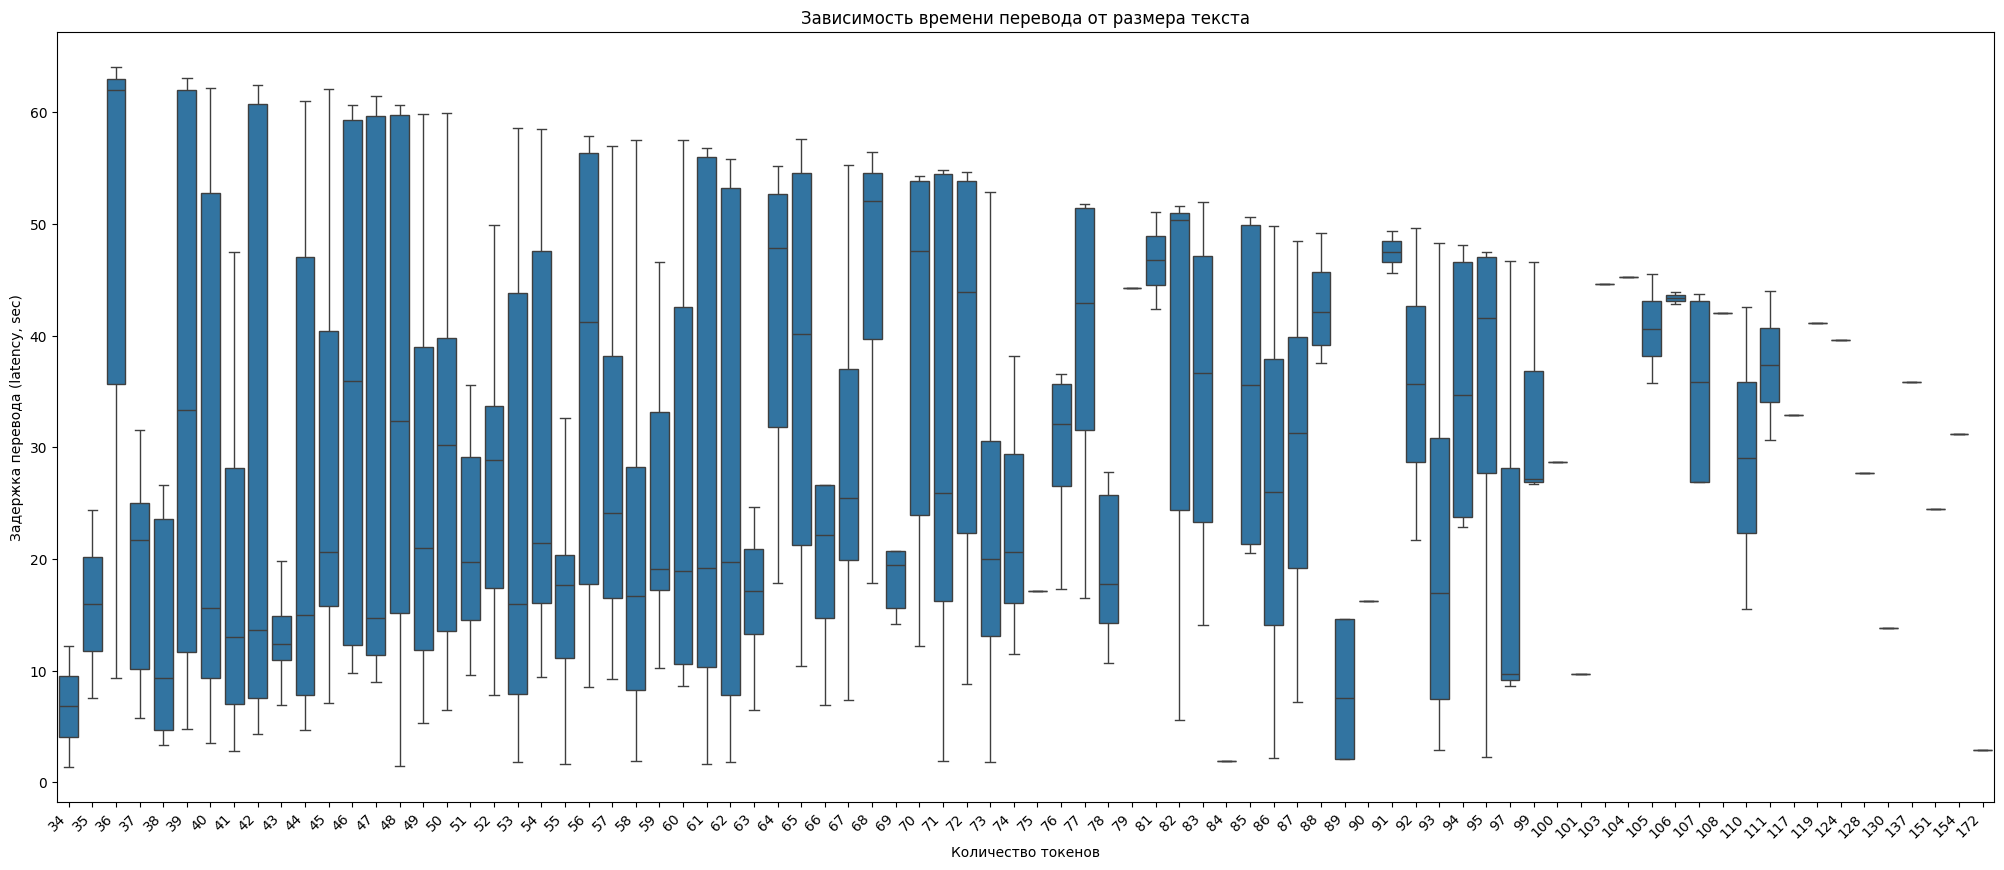

In [26]:
plt.figure(figsize=(25,10)) # задание размера фигуры
sns.boxplot(x=tokens_count, y=latency, showfliers=False) # строим "ящики с усами", showfliers — отображать ли выбросы
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Зависимость времени перевода от размера текста") # название фигуры
plt.xlabel("Количество токенов") # подпись по оси x
plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
plt.show() # показ фигуры

In [27]:
results = pd.DataFrame({"Tokens count": tokens_count, "Latency": latency}) # собираем данные в DataFrame
results.sort_values(by=["Tokens count"], inplace=True)
results.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)
results

,Tokens count,Latency
0,34,12.249269
1,34,1.381382
2,35,24.360783
3,35,7.576004
4,36,9.329154
...,...,...
495,130,13.811613
496,137,35.881877
497,151,24.524012
498,154,31.168447


In [28]:
stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                              std=("Latency", "std")
                                                             )
stats

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,mean,std
Tokens count,,
34,6.815325,7.684757
35,15.968393,11.868631
36,45.124647,31.017077
37,18.482492,10.048540
38,12.755785,9.534055
...,...,...
130,13.811613,NaN
137,35.881877,NaN
151,24.524012,NaN


Удаляем записи-выбросы (оставляем только те записи, у которых отличие от среднего значения не более трёх стандартных отклонений).

In [29]:
outlier_indexes = []

for index in results.index:
    tokens_count_, latency_ = results.loc[index]
    if np.abs(latency_ - stats.loc[tokens_count_]["mean"]) > 3 * stats.loc[tokens_count_]["std"]:
        outlier_indexes.append(index)

results.drop(outlier_indexes, inplace=True)
results

,Tokens count,Latency
0,34,12.249269
1,34,1.381382
2,35,24.360783
3,35,7.576004
4,36,9.329154
...,...,...
495,130,13.811613
496,137,35.881877
497,151,24.524012
498,154,31.168447


Пересчитываем значения статистик без выбросов.

In [30]:
stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                              std=("Latency", "std")
                                                             )
stats

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,mean,std
Tokens count,,
34,6.815325,7.684757
35,15.968393,11.868631
36,45.124647,31.017077
37,18.482492,10.048540
38,12.755785,9.534055
...,...,...
130,13.811613,NaN
137,35.881877,NaN
151,24.524012,NaN


Строим $y=ax+b$ линейную аппроксимацию графика, чтобы найти коэффициенты увеличения времени от размера текста.

In [31]:
a, b = np.polyfit(stats.index[:75], stats["mean"][:75], deg=1) # считаем линейную аппроксимацию (deg=1), [:75] — так как после идёт большой разброс по времени из-за малой представленности в датасете
print(f"Затрачиваемое время увеличивается, в среднем, на {a:.5f} секунд за каждый новый токен, при этом модель работает не менее {b:.5f} секунд.")

Затрачиваемое время увеличивается, в среднем, на 0.13391 секунд за каждый новый токен, при этом модель работает не менее 20.22426 секунд.


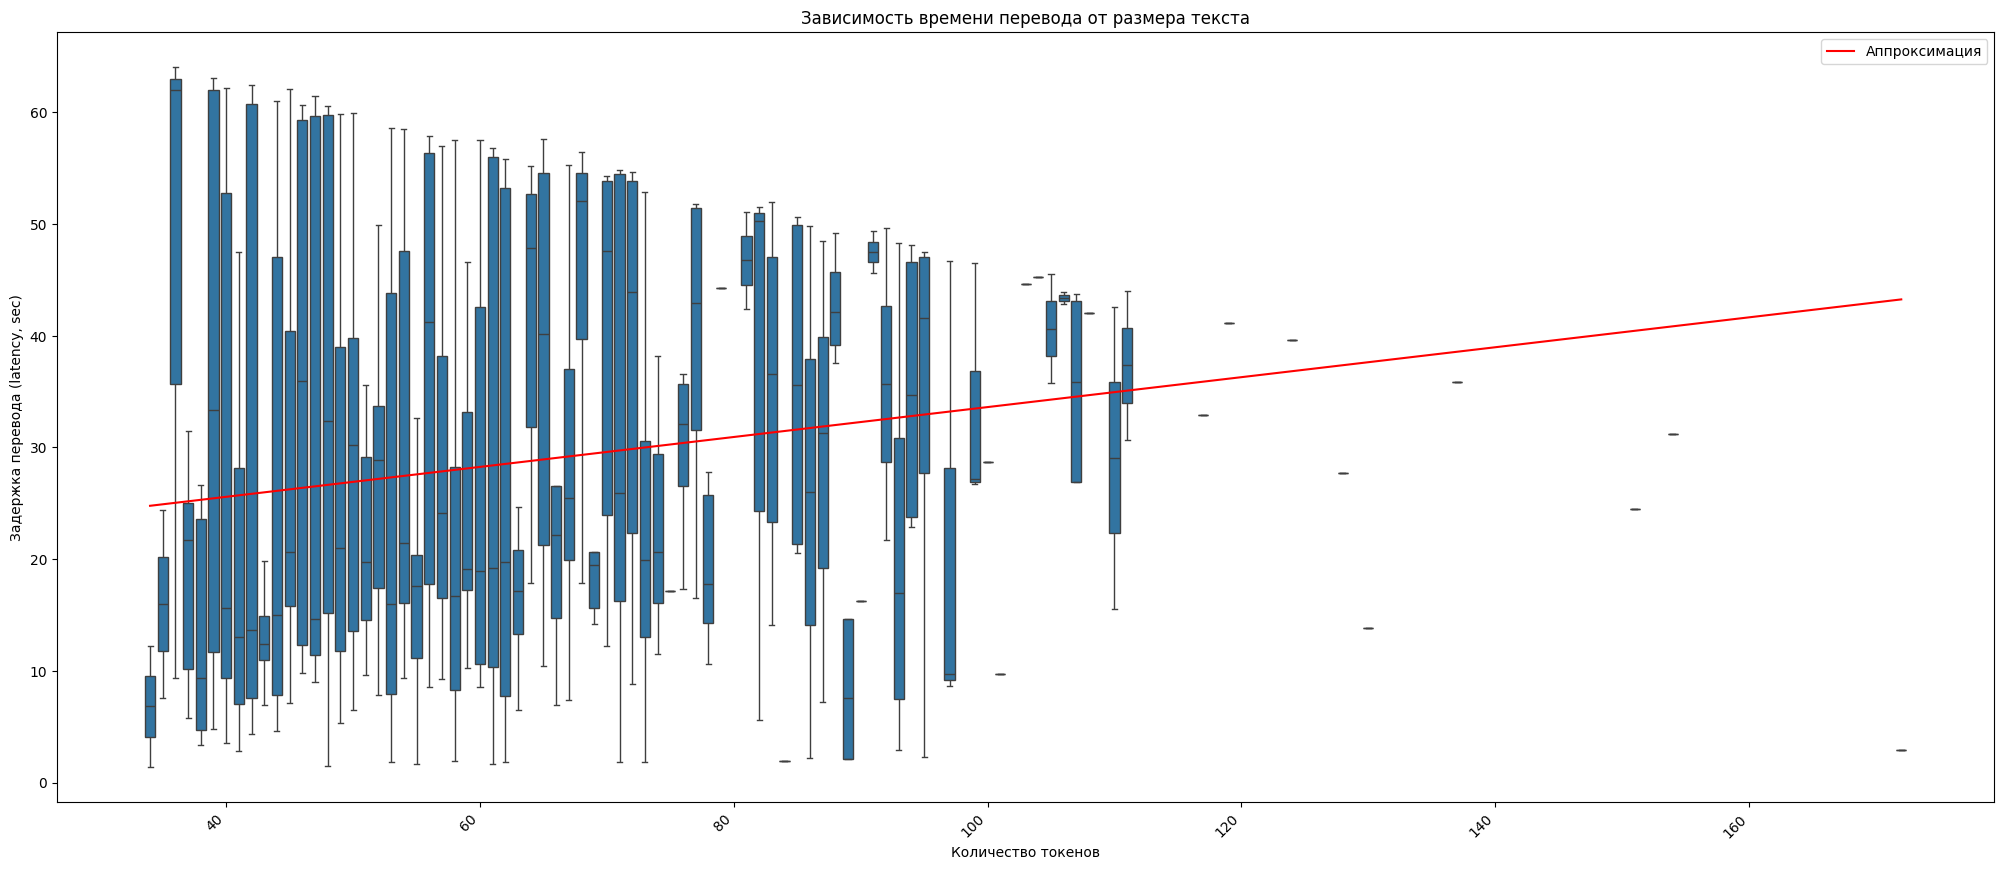

In [32]:
plt.figure(figsize=(25,10)) # задание размера фигуры
sns.boxplot(x=results["Tokens count"], y=results["Latency"], native_scale=True, showfliers=False) # строим "ящики с усами", showfliers — отображать ли выбросы, native_scale — воспринимать ли ось X как непрерывную (а не категориальную)

x = np.linspace(stats.index[0], stats.index[-1])
# x = stats.index.to_numpy() # рассмотренные значения по оси x для линейного графика
y = a * x + b
sns.lineplot(x=x, y=y, color="red", label="Аппроксимация")
# sns.pointplot(x=x, y=y, color="red", label="Аппроксимация") # pointplot в данном случае идёт как аналог линейного графика, у которого ось X воспринимается "категориально", то есть так же, как в boxplot

plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Зависимость времени перевода от размера текста") # название фигуры
plt.xlabel("Количество токенов") # подпись по оси x
plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
plt.legend() # отображение подписей графиков
plt.show() # показ фигуры

In [33]:
metric_BLEU = evaluate.load("bleu") # загружаем метрику

In [34]:
metric_BLEU.compute(predictions=translations, references=dataset["test"]["tgt"][:TEST_MAX_SAMPLES]) # считаем значение метрики
# metric_BLEU.compute(predictions=translations, references=[[ref] for ref in dataset["test"]["tgt"][:TEST_MAX_SAMPLES]]) # считаем значение метрики

{'bleu': 0.007793092132458511,
 'precisions': [0.04614623963083008,
  0.008296444778529468,
  0.004261684353127117,
  0.0022606306873461913],
 'brevity_penalty': 1.0,
 'length_ratio': 3.2586824203365556,
 'translation_length': 36406,
 'reference_length': 11172}